## Titanic: Machine Learning from Disaster

Start here! Predict survival on the Titanic and get familiar with ML basics

In [352]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

trainset = 'train_Titanic.csv'
df = pd.read_csv(trainset)
testset = 'test_Titanic.csv'
df_test = pd.read_csv(testset)

In [353]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [354]:
# Let's see the data description

print('Data Dimension: ', df.shape, '\n', '\n', df.describe(), '\n') 
print('List of Columns: ', df.columns.values, '\n')

Data Dimension:  (891, 12) 
 
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200   

List of Columns:  ['PassengerId' 'Survived' 'Pcl

In [383]:
df['Embarked'].value_counts(), df['Cabin'].unique()

(0    645
 1    168
 2     77
 Name: Embarked, dtype: int64, array([1., 2., 4., 6., 3., 0., 5.]))

In [356]:
# Let's first drop a couple of columns that are unnecessary for prediction

df = df.drop(['PassengerId','Name','Ticket'],axis=1)

In [357]:
# I will replace NaNs with either the Median or the Mode here for these features 

df.Cabin.fillna(df.Cabin.mode()[0], inplace=True) # with the Mode
df.Age.fillna(df['Age'].median(), inplace=True) # with the median
df.Embarked.fillna(df['Embarked'].mode()[0], inplace=True) # with the mode

# And create dummy variable for Sex and Embarked Destinations

df.Sex=df.Sex.map({'male':0, 'female':1})
df.Embarked=df.Embarked.map({'S':0,'C':1,'Q':2})

# With Cabin feature, I will just care about the beginning letter of a cabin number: from A-G. 
# We will ignore the following numerical part.
for letter in df['Cabin']:
    df.Cabin = df.Cabin.replace(letter,letter[0])
    
# Now that we already convert the Cabin # to just a letter from A to G, let's assign them to a number from 0 to 6
df.Cabin = df.Cabin.map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6})

In [358]:
# Check to see if we still miss any NaNs

hasNAN = df.isnull().sum()
print(hasNAN)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       1
Embarked    0
dtype: int64


#### Well, there is still 1 NaN in the on of the Cabin columns

In [359]:
df = df.dropna(how='any') 

In [360]:
hasNAN = df.isnull().sum()
print(hasNAN)
print(df['Cabin'].unique())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64
[1. 2. 4. 6. 3. 0. 5.]


#### Well I know what is wrong with this one NaN in the Cabin feature. The entry is nan, not NaN, so that's why we missed it when we try to replace it with a numerical value

### Let's visualize the data just to get a general idea of how good some variables are as predictors

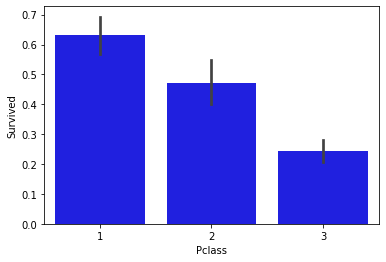

In [393]:
# Pclass and Survival Rate

sns.barplot(df['Pclass'],df.Survived, color='blue')

#### I can be said that Pclass alone is not as good a predictor of survival rate as I thought. 

### Model and Prediction

We are going to use Support Vector Machine (SVM) for this problem

In [362]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,1.0,0
1,1,1,1,38.0,1,0,71.2833,2.0,1
2,1,3,1,26.0,0,0,7.9250,1.0,0
3,1,1,1,35.0,1,0,53.1000,2.0,0
4,0,3,0,35.0,0,0,8.0500,1.0,0


In [363]:
X_train = df[:890].drop('Survived',axis=1)
Y_train = df['Survived']

X_train.shape, Y_train.shape

((890, 8), (890,))

In [364]:
from sklearn.svm import SVC 
svc = SVC(kernel='linear')

svc.fit(X_train,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [365]:
# Let's modify the testset a little bit before we test our model with it 

df_test=df_test.drop(['PassengerId','Name','Ticket'],axis=1)

# NaN Handling
df_test.Cabin.fillna(df_test.Cabin.mode()[0], inplace=True) # with the Mode
df_test.Age.fillna(df_test['Age'].median(), inplace=True) # with the median
df_test.Embarked.fillna(df_test['Embarked'].mode()[0], inplace=True) # with the mode

# Dummy Variables
df_test.Sex=df_test.Sex.map({'male':0, 'female':1})
df_test.Embarked=df_test.Embarked.map({'S':0,'C':1,'Q':2})

# Same for df_test['Cabin']
for word in df_test['Cabin']:
    df_test.Cabin = df_test.Cabin.replace(word,word[0])
    
# Now that we already convert the Cabin # to just a letter from A to G, let's assign them to a number from 0 to 6
df_test.Cabin = df_test.Cabin.map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6})
df_test = df_test.dropna(how='any')

print(df_test.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Cabin  Embarked
0       3    0  34.5      0      0   7.8292      1         2
1       3    1  47.0      1      0   7.0000      1         0
2       2    0  62.0      0      0   9.6875      1         2
3       3    0  27.0      0      0   8.6625      1         0
4       3    1  22.0      1      1  12.2875      1         0


In [400]:
X_test = df_test[::]

Y_pred_SVC = svc.predict(X_test)

In [401]:
test_data = pd.read_csv('gender_submission.csv')

Y_test = test_data['Survived'][1:]


from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test,Y_pred_SVC))

[[225  40]
 [ 40 112]]


In [402]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred_SVC)) # My model is about 80% correct in predicting the test dataset.

0.8081534772182254


In [403]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction_RF = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [404]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_prediction_RF))

0.697841726618705


In [406]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred_LR = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(accuracy_score(Y_test,Y_pred_LR))


0.7793764988009593


c:\users\tram ngo\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [407]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred_Bayes = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(accuracy_score(Y_test,Y_pred_Bayes))

0.7074340527577938


### The End